# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [33]:
%reload_ext autoreload
%autoreload 2

In [1]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [2]:
import os

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

## Load data

In [3]:

phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  526


class          x          y         r
experiment sample                                           
phi-0.86   sample-245      1 -21.345870 -15.024694  0.730000
           sample-245      2  20.038204 -19.199467  0.776842
           sample-245      3 -19.955206 -14.443004  0.823684
           sample-245      6 -13.669206 -10.131996  0.964211
           sample-245      4  -9.936614  -7.810038  0.870526
...                      ...        ...        ...       ...
           sample-468      2  15.738703 -21.721624  0.776842
           sample-468      3 -19.316748 -18.640416  0.823684
           sample-468     10  21.513569 -16.596960  1.151579
           sample-468      4 -17.922827 -19.644332  0.870526
           sample-468      6 -20.417054 -13.410191  0.964211

[1052000 rows x 4 columns]

In [4]:
dataframe.describe().round(2)

,class,x,y,r
count,1052000.00,1052000.00,1052000.00,1052000.00
mean,6.53,-0.00,0.01,0.99
std,5.11,12.56,12.55,0.24
min,1.00,-21.75,-21.75,0.73
25%,2.00,-10.89,-10.86,0.78
50%,5.00,-0.00,0.00,0.92
75%,10.00,10.87,10.87,1.15
max,20.00,21.75,21.75,1.62


In [5]:
class StaticMinMaxScaler(object):
    def __init__(self, columns, maximum, minimum):
        self.columns = columns
        self.min = np.array(minimum)
        self.max = np.array(maximum)

    def fit(self, df):
        self.min = df.loc[:, self.columns].min(axis=0)
        self.max = df.loc[:, self.columns].max(axis=0)
        return self

    def __call__(self, df):
        new_df = df.copy()
        new_df.loc[:, self.columns] = (new_df.loc[:, self.columns] - self.min) / (
            self.max - self.min
        )
        return new_df

    def transform(self, df):
        return self.__call__(df)
    
    def fit_transform(self, df):
        self.columns = df.columns
        self = self.fit(df)
        return self(df)

    def inverse_transform(self, df):
        new_df = df.copy()
        new_df.loc[:, self.columns] = (
            new_df.loc[:, self.columns] * (self.max - self.min)
        ) + self.min
        return new_df

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [21.74652425, 21.74652425, 21.74652425], # NOTE: Tuned for physical feasibility
    minimum = [-21.74652425, -21.74652425, -21.74652425] # NOTE: Tuned for physical feasibility
    # maximum = [21.74652425, 21.74652425, 1.62], # NOTE: Normal minmax
    # minimum = [-21.74652425, -21.74652425, 0.73]  # NOTE: Normal minmax
    # NOTE: Scale r with the higher x,y min,max -> Ensures everything is between 0,1 but also retains physical setup with linear scaling
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(2)

,x,y,r
count,1052000.00,1052000.00,1052000.00
mean,0.50,0.50,0.52
std,0.29,0.29,0.01
min,0.00,0.00,0.52
25%,0.25,0.25,0.52
50%,0.50,0.50,0.52
75%,0.75,0.75,0.53
max,1.00,1.00,0.54


Loss for unscaled dataframe:  tensor(0.0024, dtype=torch.float64)
Loss for unscaled dataframe:  tensor(0.5002, dtype=torch.float64)


Text(0.5, 1.0, 'Scaled')

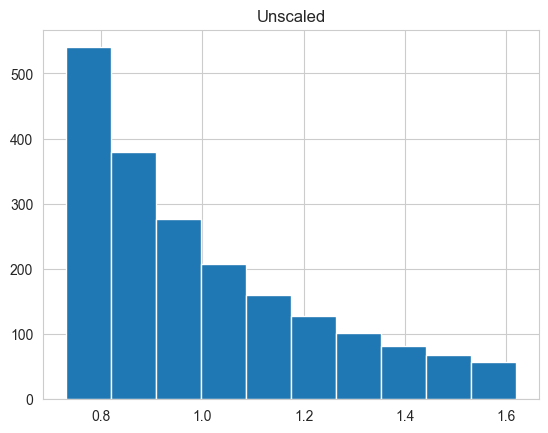

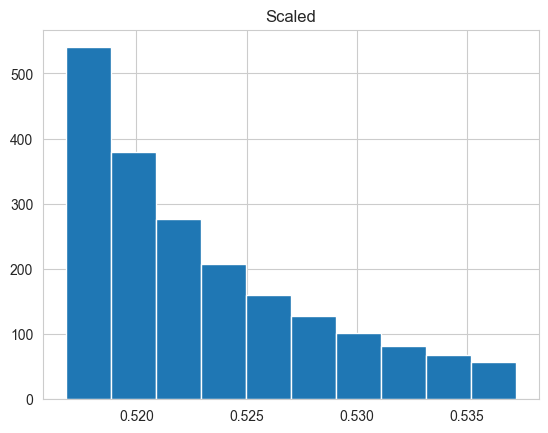

In [7]:
def _physical_feasibility_loss(fake_points, collision_loss_coefficient=1):

    # Rescale the coordinates and radii back to their original scales
    x = fake_points[:, :, 0] 
    y = fake_points[:, :, 1] 
    radii = fake_points[:, :, 2]

    # Combine rescaled values into one tensor
    rescaled_points = torch.stack((x, y, radii), dim=2)
    # Calculate the pairwise distance matrix
    # If the distance is less than the sum of the radii, then it's a collision and should be penalized

    # Calculate the pairwise distance matrix
    n = fake_points.shape[1]
    dist = torch.cdist(rescaled_points[:, :, :2], rescaled_points[:, :, :2])
    # Calculate the sum of the radii of the two points
    radii = rescaled_points[:, :, 2].unsqueeze(1).abs() + rescaled_points[
        :, :, 2
    ].unsqueeze(2).abs()

    # Instead of a hard limit, use a differentiable loss function
    overlap_distance = (radii - dist) / radii.sum()
    overlap_distance = nn.ReLU(inplace=False)(
        overlap_distance
    )  # Zero the negative values, the distances can be larger than radius
    overlap_distance = overlap_distance.sum() # More overlaps -> worse -> get a gradient instead of a hard boundary

    return overlap_distance * collision_loss_coefficient


sample = dataframe.copy().query("sample=='sample-245'").loc[:,["x", "y", "r"]].reset_index(drop=True)
sample = torch.tensor(sample.values).unsqueeze(0)

print("Loss for unscaled dataframe: ", _physical_feasibility_loss(sample))
plt.hist(sample[0,:,2].numpy().flatten())
plt.title("Unscaled")

sample = dataframe_scaled.copy().query("sample=='sample-245'").loc[:,["x", "y", "r"]].reset_index(drop=True)
sample = torch.tensor(sample.values).unsqueeze(0)
plt.figure()
print("Loss for unscaled dataframe: ", _physical_feasibility_loss(sample))
plt.hist(sample[0,:,2].numpy().flatten())
plt.title("Scaled")




<Axes: >

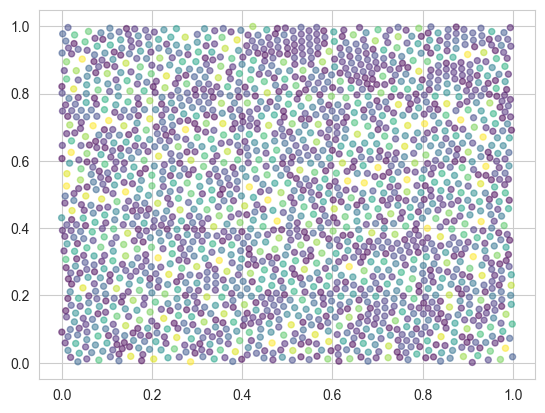

In [8]:
plot_pointcloud(sample[0], plot_radius=True)

### Attempt: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


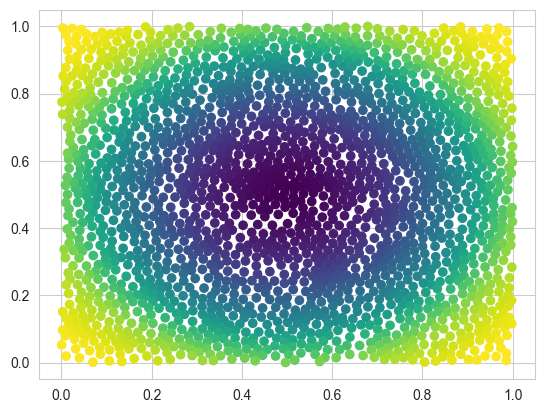

In [9]:
_X = dataframe_scaled.copy()


_X["Xy"] = _X["x"] + _X["y"] # Think about starting from center and going radially outwards
_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))

_X = _X.query("experiment=='phi-0.86'&sample=='sample-1'")

_X = _X.sort_values(by=["Xy", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)


This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [10]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered["Xy"] = np.sqrt(((dataframe_scaled_ordered["x"]-0.5)**2) + ((dataframe_scaled_ordered["y"]-0.5)**2))
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "Xy"])
dataframe_scaled_ordered = dataframe_scaled_ordered.drop(columns=["Xy"])

dataframe_scaled_ordered.head(10)

x         y         r
experiment sample                                
phi-0.86   sample-1  0.494921  0.505479  0.524323
           sample-1  0.514189  0.492870  0.521092
           sample-1  0.494823  0.482417  0.520015
           sample-1  0.515806  0.513535  0.520015
           sample-1  0.478714  0.491918  0.516784
           sample-1  0.501485  0.526404  0.517861
           sample-1  0.471081  0.508716  0.520015
           sample-1  0.482477  0.526136  0.520015
           sample-1  0.513501  0.470257  0.520015
           sample-1  0.530115  0.480518  0.517861

## Build dataset

Creating Dataset
Descriptor List:  ['phi']
torch.Size([526, 1, 1])
torch.Size([526, 400, 2])


<Axes: >

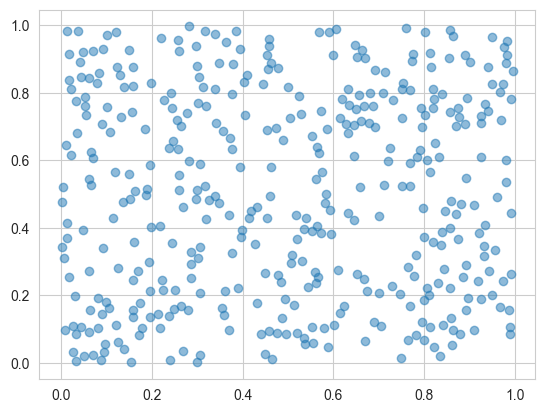

In [113]:
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled.drop(columns=["r"], inplace=False).copy(), # Dont use the ordering
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0}, 
    downsample=0.2
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=False)

In [114]:
dataset.samples[0].shape

torch.Size([1, 400, 2])

## Note: Samples are order invariant in the sample size dimension

<Axes: >

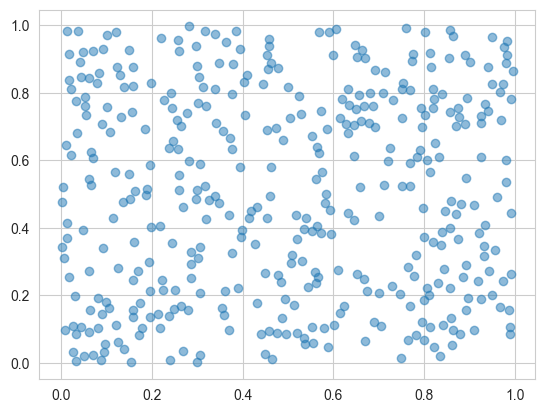

In [115]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)

## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

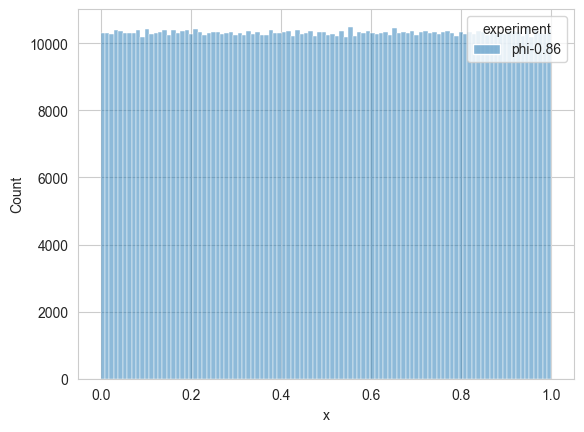

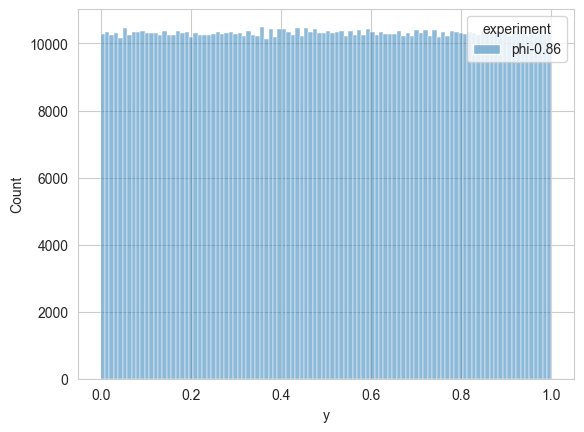

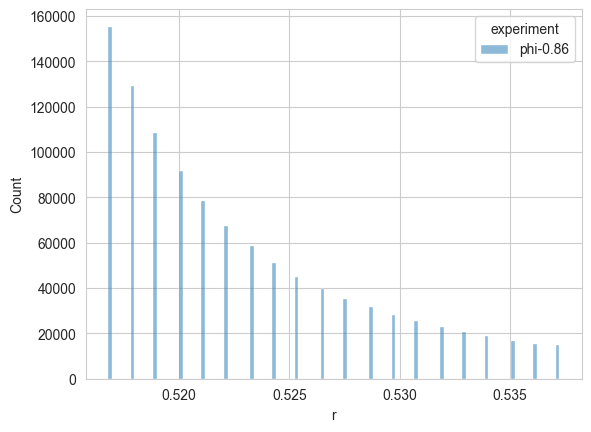

In [116]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [117]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

print(sample_x.shape, sample_y.shape)


torch.Size([32, 1, 1]) torch.Size([32, 400, 2])


In [173]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
kernel_size = (3,3) # if 3x3, the output x,y,r will correlate with each other
stride = (1,1)

from src.models.CryinGAN import Generator, CCCGenerator

out_samples = dataset.samples[0].shape[1]

generator_model_2 = CCCGenerator(kernel_size=1, stride=1,
    rand_features=64, out_dimensions=2, out_samples=400).to("mps")

# sample_x = sample_x.to("mps")
print(sample_x.shape)
_out = generator_model_2(sample_x).detach().cpu().numpy()
print(_out.shape)

print(summary(generator_model_2, input_data=sample_x, depth=2))


# plot_pointcloud(_out[0], plot_radius=False)
# plt.xlim(0,1)
# plt.ylim(0,1)

torch.Size([32, 1, 1])
(32, 400, 3)
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 400, 3]              --
├─Sequential: 1-1                        [32, 400, 3]              --
│    └─Linear: 2-1                       [32, 2400]                156,000
│    └─ReLU: 2-2                         [32, 2400]                --
│    └─Unflatten: 2-3                    [32, 6, 400, 1]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 400, 3]         4,864
│    └─BatchNorm2d: 2-5                  [32, 256, 400, 3]         512
│    └─ReLU: 2-6                         [32, 256, 400, 3]         --
│    └─ConvTranspose2d: 2-7              [32, 128, 400, 3]         32,896
│    └─BatchNorm2d: 2-8                  [32, 128, 400, 3]         256
│    └─ReLU: 2-9                         [32, 128, 400, 3]         --
│    └─ConvTranspose2d: 2-10             [32, 64, 400, 3]          8,256
│    └─BatchNorm2d: 2-11        

In [206]:
layer = nn.Sequential(
            # Convolutional layer 2
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            # # # # Convolutional layer 2
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            # # Convolutional layer 3
            nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.AvgPool2d((500, 1)),
            nn.AdaptiveAvgPool2d(1),
            # nn.Flatten(1, -1),
        )

test_input = torch.rand(1,64,12,6)

print(layer(test_input).shape)

torch.Size([1, 256, 1, 1])


In [210]:
import torch
import torch.nn as nn
from src.models.CryinGAN import Discriminator2D, CCCGDiscriminator


# Initialize the discriminator
input_channels = sample_y.shape[-1] # For fractional coordinates
in_samples = sample_y.shape[1] # For fractional coordinates
discriminator_model_2 = CCCGDiscriminator(input_channels=input_channels, in_samples=in_samples).to("mps")

# Print the discriminator architecture

# Example input with batch size of 16 and 3 input channels (for fractional coordinates)
batch_size = 32
# Generate output

_sample_y = sample_y.to("mps")

print(_sample_y.shape)
output = discriminator_model_2(_sample_y)
print(output.shape)

summary(discriminator_model_2, input_data=_sample_y, depth=2)

torch.Size([32, 400, 2])
torch.Size([32, 1])


Layer (type:depth-idx)                   Output Shape              Param #
CCCGDiscriminator                        [32, 1]                   --
├─Sequential: 1-1                        [32, 256]                 --
│    └─Conv2d: 2-1                       [32, 64, 400, 1]          192
│    └─LeakyReLU: 2-2                    [32, 64, 400, 1]          --
│    └─Conv2d: 2-3                       [32, 128, 400, 1]         8,320
│    └─LeakyReLU: 2-4                    [32, 128, 400, 1]         --
│    └─Conv2d: 2-5                       [32, 256, 400, 1]         33,024
│    └─LeakyReLU: 2-6                    [32, 256, 400, 1]         --
│    └─AdaptiveAvgPool2d: 2-7            [32, 256, 1, 1]           --
│    └─Flatten: 2-8                      [32, 256]                 --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Linear: 2-9                       [32, 200]                 51,400
│    └─LeakyReLU: 2-10                   [32, 200]                 --
│  

## Train the model

In [211]:
run_params = {
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 300,
        "early_stopping_patience": 30, # Disabled
        "early_stopping_headstart": 20,
        "log_image_frequency": 1,
        "generator_headstart": 0,
        "training_ratio_dg": 5,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.0002,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.0002,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 loss
            "mu": 5, # L1 loss coefficient
            # "name": "BCELoss", # Baseline
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1,
            "physical_feasibility_loss": 0,
            "collision_loss_coefficient": 0,
        }
    },
    # "generator": {
    #     "output_max_samples": dataset.y.shape[1],
    #     "in_dim": 3,
    #     "latent_dim": 3,
    #     "cnn_channels": 8,
    #     "output_max_samples": 2000,
    #     "kernel_y":4000,
    #     "kernel_x":5,
    #     "latent2pointcloud_layers":0, # input and output are excluded so n + 2
    # },
    # "discriminator": {
    #     "channels_img":1,
    #     "features_d": 32
    # }
}
run_params

{'training': {'device': 'mps',
  'batch_size': 32,
  'epochs': 300,
  'early_stopping_patience': 30,
  'early_stopping_headstart': 20,
  'log_image_frequency': 1,
  'generator_headstart': 0,
  'training_ratio_dg': 5,
  'optimizer_g': {'name': 'Adam',
   'lr': 0.0002,
   'weight_decay': 0,
   'betas': (0.5, 0.999)},
  'optimizer_d': {'name': 'Adam',
   'lr': 0.0002,
   'weight_decay': 0,
   'betas': (0.5, 0.999)},
  'd_loss': {'name': 'CryinGANDiscriminatorLoss', 'mu': 5},
  'g_loss': {'name': 'HSGeneratorLoss',
   'radius_loss': 0,
   'grid_density_loss': 0,
   'gan_loss': 1,
   'physical_feasibility_loss': 0,
   'collision_loss_coefficient': 0}}}

In [214]:
test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

len(trainset), len(testset)

# generator = CCCGenerator(rand_features=64, kernel_size=(3,3), stride=1).to("mps")
# discriminator = CCCGDiscriminator(input_channels).to("mps")

out_samples = dataset.samples[0].shape[1]
out_dimensions = dataset.samples[0].shape[2]

# generator = Generator(kernel_size=kernel_size, stride=stride, rand_features=32, out_dimensions=out_dimensions, out_samples=out_samples).to("mps")
generator = CCCGenerator(kernel_size=kernel_size, stride=stride,rand_features=32, out_dimensions=out_dimensions, out_samples=out_samples).to("mps")
discriminator = CCCGDiscriminator(input_channels=input_channels, in_samples=out_samples).to("mps")

# generator = torch.compile(generator, backend="aot_eager") # NOTE: MPS is not supported by PyTorch Compile
# discriminator = torch.compile(discriminator, backend="aot_eager") # NOTE: MPS is not supported by PyTorch Compile

gan = GAN(
    dataset, 
    dataset,# No separate test set
    generator_model=generator,
    discriminator_model=discriminator,
    **run_params
    )

print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y, depth=2))

Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 400, 3]              --
├─Sequential: 1-1                        [32, 400, 3]              --
│    └─Linear: 2-1                       [32, 2400]                79,200
│    └─ReLU: 2-2                         [32, 2400]                --
│    └─Unflatten: 2-3                    [32, 6, 400, 1]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 400, 3]         4,864
│    └─BatchNorm2d: 2-5                  [32, 256, 400, 3]         512
│    └─ReLU: 2-6                         [32, 256, 400, 3]         --
│    └─ConvTranspose2d: 2-7              [32, 128, 400, 3]         32,896
│    └─BatchNorm2d: 2-8                  [32, 128, 400, 3]         256
│    └─ReLU: 2-9                         [32, 128, 400, 3]         --
│    └─ConvTranspose2d: 2-10             [32, 64, 400, 3]          8,256
│    └─BatchNorm2d: 2-11                 [32, 64, 400, 3]          12

2024/07/17 15:58:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/17 15:58:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run sun-river-7751c182-34c2-43bc-9219-17df1fac90b5...
Time: 2024-07-17 15:58:38


2024/07/17 15:58:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/17 15:58:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


RuntimeError: unflatten: Provided sizes [2, 400] don't multiply up to the size of dim 1 (1200) in the input tensor

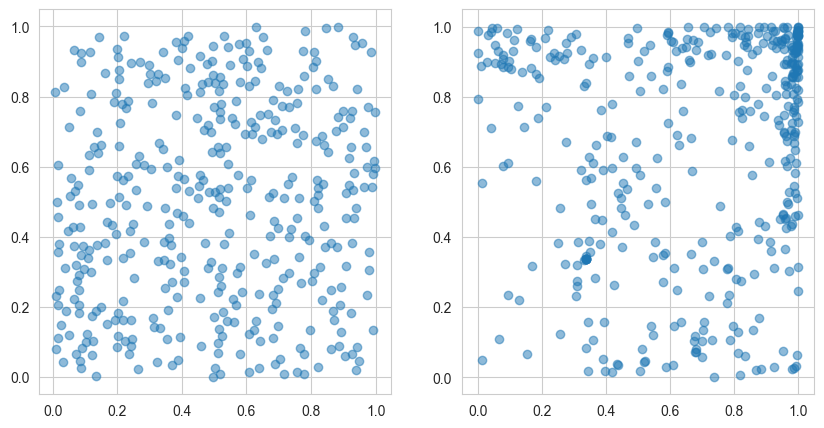

In [215]:
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name="Baseline (no R, small sample(400))",
)

<Axes: >

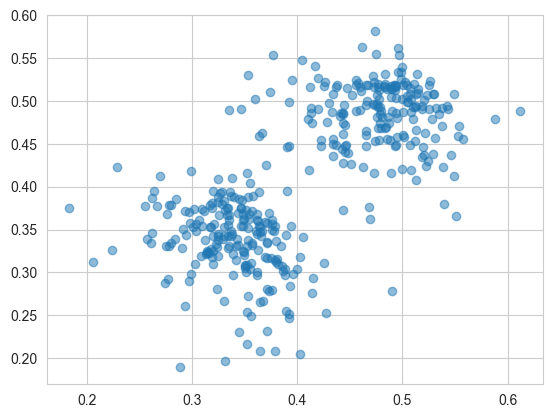

In [145]:
_out = gan.generate(sample_x)[0]
# _out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)


<Figure size 640x480 with 0 Axes>

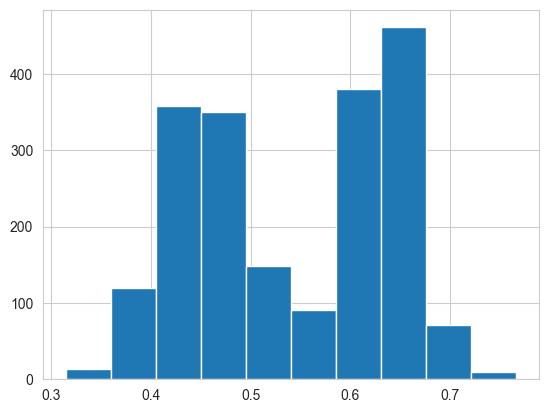

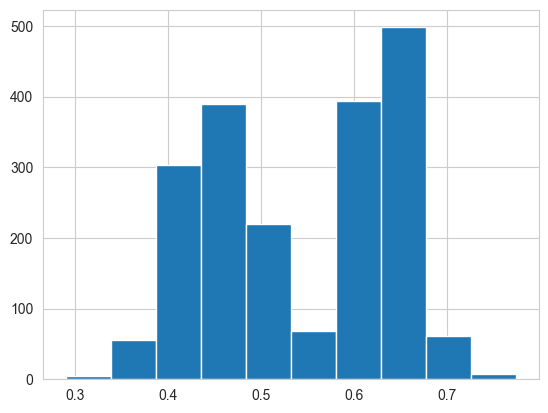

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [44]:
plt.hist(_out[:,0])
plt.figure()
plt.hist(_out[:,1])
plt.figure()
# plt.hist(_out[:,2])
plt.figure()


In [ ]:
# Run hyper parameter optimization
from time import sleep
 
# Define the hyperparameter search space

batch_sizes = [16, 32, 64]
lrs_d = [0.002, 0.0002, 0.00002]
lrs_g = [0.002, 0.0002, 0.00002]

# Run experiments

try:
    for batch_size in batch_sizes:
        for lr_d in lrs_d:
            for lr_g in lrs_g:
                this_run_params = deepcopy(run_params)
                this_run_params["training"]["batch_size"] = batch_size
                this_run_params["training"]["optimizer_g"]["lr"] = lr_g
                this_run_params["training"]["optimizer_d"]["lr"] = lr_d
                gan = GAN(
                    trainset,
                    testset,
                    generator_model=Generator2().to("mps"),
                    discriminator_model=Discriminator(input_channels).to("mps"),
                    **this_run_params
                )
                gan.train_n_epochs(
                    epochs=this_run_params["training"]["epochs"],
                    batch_size=this_run_params["training"]["batch_size"],
                    experiment_name="LR/BS Study",
                    comment="",
                )

                sleep(3) # Gives some time to do a keyboardinterrupt
except KeyboardInterrupt:
    print("Interrupted")

2024/07/11 12:11:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:11:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run sun-beach-7b9e888c-12e0-4a4c-93da-73f5be58ab70...
Time: 2024-07-11 12:11:45


 36%|███▌      | 36/100 [03:42<06:34,  6.17s/it]
2024/07/11 12:15:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:15:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Interrupted


2024/07/11 12:15:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:15:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-sun-78dd1c4a-f213-44ba-8ac2-8ac44f0417fa...
Time: 2024-07-11 12:15:30


 53%|█████▎    | 53/100 [05:34<04:57,  6.32s/it]
2024/07/11 12:21:05 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:21:05 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Interrupted


2024/07/11 12:21:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:21:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run forest-cloud-6af7d78d-731f-4d84-af08-1b8b1e36874b...
Time: 2024-07-11 12:21:08


100%|██████████| 100/100 [09:45<00:00,  5.86s/it]
2024/07/11 12:30:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:30:54 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 12:30:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:30:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run star-river-5a12b5f9-7f8c-4490-9565-0d6a6e2912ec...
Time: 2024-07-11 12:30:57


100%|██████████| 100/100 [09:45<00:00,  5.86s/it]
2024/07/11 12:40:44 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:40:44 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 12:40:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:40:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-car-868e1cb3-eb57-4cf8-949b-b0ad3a7c6d57...
Time: 2024-07-11 12:40:47


 81%|████████  | 81/100 [08:00<01:52,  5.94s/it]
2024/07/11 12:48:48 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:48:48 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 12:48:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:48:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-moon-d76dbff0-e1d0-4eba-83ec-42b959cd5199...
Time: 2024-07-11 12:48:51


100%|██████████| 100/100 [09:46<00:00,  5.86s/it]
2024/07/11 12:58:37 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 12:58:37 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 12:58:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 12:58:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run car-star-4d3997a6-439f-497b-8ef6-63fa01cfded4...
Time: 2024-07-11 12:58:40


100%|██████████| 100/100 [09:48<00:00,  5.88s/it]
2024/07/11 13:08:29 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:08:29 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 13:08:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:08:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run cloud-moon-d75ece2a-7f7b-44a3-ab7f-b37963322c9c...
Time: 2024-07-11 13:08:32


100%|██████████| 100/100 [09:48<00:00,  5.88s/it]
2024/07/11 13:18:20 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:18:20 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 13:18:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:18:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run star-sun-3284bcf9-7bfc-4864-a01a-00e947607db6...
Time: 2024-07-11 13:18:23


100%|██████████| 100/100 [09:48<00:00,  5.88s/it]
2024/07/11 13:28:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:28:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 13:28:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:28:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run mountain-beach-f7113073-7a0f-4416-94c7-e919985c2e03...
Time: 2024-07-11 13:28:15


 50%|█████     | 50/100 [05:00<05:00,  6.00s/it]
2024/07/11 13:33:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:33:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 13:33:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:33:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-river-7d74b85f-ab89-4c22-bb4f-a982ba927d1c...
Time: 2024-07-11 13:33:18


100%|██████████| 100/100 [09:48<00:00,  5.89s/it]
2024/07/11 13:43:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:43:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 13:43:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:43:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run car-beach-f0289ad2-85c7-41cf-a590-3fe9533a44da...
Time: 2024-07-11 13:43:11


100%|██████████| 100/100 [09:45<00:00,  5.85s/it]
2024/07/11 13:52:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:52:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 13:52:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:52:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run car-forest-4d0a1407-3b74-4c4e-a48d-6a935246a8b1...
Time: 2024-07-11 13:52:59


 51%|█████     | 51/100 [05:04<04:52,  5.96s/it]
2024/07/11 13:58:03 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 13:58:03 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 13:58:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 13:58:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-tree-b0ac6a53-49d5-44ab-abe4-a9c9efef97a1...
Time: 2024-07-11 13:58:07


100%|██████████| 100/100 [09:49<00:00,  5.90s/it]
2024/07/11 14:07:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:07:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 14:08:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:08:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run moon-moon-83c22a8c-cdfd-41e5-95bd-4e9aa93bea6c...
Time: 2024-07-11 14:08:00


100%|██████████| 100/100 [09:52<00:00,  5.92s/it]
2024/07/11 14:17:52 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:17:52 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 14:17:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:17:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-tree-fa490889-f1c7-46d4-a674-b1de95bfb7af...
Time: 2024-07-11 14:17:55


100%|██████████| 100/100 [09:55<00:00,  5.95s/it]
2024/07/11 14:27:51 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:27:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 14:27:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:27:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-moon-5c488862-1ffc-4f68-a552-b1aa72918776...
Time: 2024-07-11 14:27:54


100%|██████████| 100/100 [09:51<00:00,  5.91s/it]
2024/07/11 14:37:46 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:37:46 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 14:37:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:37:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run forest-beach-d7eb9baf-e9e7-49a7-8e6c-f0b2e8f8d80c...
Time: 2024-07-11 14:37:49


100%|██████████| 100/100 [09:55<00:00,  5.95s/it]
2024/07/11 14:47:44 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:47:44 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 14:47:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:47:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run river-cloud-3f1e2090-5011-496b-8239-42fc7650f632...
Time: 2024-07-11 14:47:47


 91%|█████████ | 91/100 [10:29<01:02,  6.91s/it]
2024/07/11 14:58:16 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 14:58:16 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 14:58:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 14:58:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run star-mountain-ed60ab8b-7002-4d5d-9b6e-21b315ce849a...
Time: 2024-07-11 14:58:20


 50%|█████     | 50/100 [05:48<05:48,  6.98s/it]
2024/07/11 15:04:09 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:04:09 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 15:04:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:04:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run mountain-moon-371b1f5d-13f9-4ac2-8adb-36ec76c2e171...
Time: 2024-07-11 15:04:12


100%|██████████| 100/100 [11:22<00:00,  6.82s/it]
2024/07/11 15:15:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:15:35 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 15:15:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:15:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-forest-80d4188d-b7e6-43bd-87fb-d383f91cfe56...
Time: 2024-07-11 15:15:38


100%|██████████| 100/100 [11:23<00:00,  6.84s/it]
2024/07/11 15:27:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:27:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 15:27:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:27:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-forest-d58af057-88f6-44db-8432-6bed680fc430...
Time: 2024-07-11 15:27:05


100%|██████████| 100/100 [11:31<00:00,  6.91s/it]
2024/07/11 15:38:37 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:38:37 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 15:38:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:38:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run star-moon-1e84e296-c8a5-42b3-8d5d-e71b7cc08a36...
Time: 2024-07-11 15:38:40


 50%|█████     | 50/100 [05:54<05:54,  7.10s/it]
2024/07/11 15:44:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:44:35 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 15:44:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:44:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run forest-river-1df37bc3-665d-4c1a-bbed-8e58675b192a...
Time: 2024-07-11 15:44:38


 75%|███████▌  | 75/100 [08:44<02:54,  7.00s/it]
2024/07/11 15:53:23 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 15:53:23 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Early stopping


2024/07/11 15:53:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 15:53:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run moon-cloud-8af7593a-4e34-4933-9e67-6ae36e2c98cc...
Time: 2024-07-11 15:53:26


100%|██████████| 100/100 [11:31<00:00,  6.91s/it]
2024/07/11 16:04:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 16:04:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/07/11 16:05:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 16:05:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run moon-car-6cf201c1-23e0-4017-b7a6-348b6ab23a34...
Time: 2024-07-11 16:05:01


100%|██████████| 100/100 [11:31<00:00,  6.91s/it]
2024/07/11 16:16:33 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 16:16:33 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [41]:

grid_density_loss_opts = [0, 1]
radius_loss_opts = [0, 1]
physical_feasibility_loss_opts = [0,1]

collision_loss_coefficient_opts = [1,2,5,10]

# Run experiments
i = 0
try:
    for collision_loss_coefficient in collision_loss_coefficient_opts:
        for grid_density_loss in grid_density_loss_opts:
            for radius_loss in radius_loss_opts:
                for physical_feasibility_loss in physical_feasibility_loss_opts:

                    this_run_params = deepcopy(run_params)

                    this_run_params["training"]["g_loss"]["grid_density_loss"] = grid_density_loss
                    this_run_params["training"]["g_loss"]["radius_loss"] = radius_loss
                    this_run_params["training"]["g_loss"]["physical_feasibility_loss"] = physical_feasibility_loss
                    this_run_params["training"]["g_loss"]["collision_loss_coefficient"] = collision_loss_coefficient

                    gan = GAN(
                        trainset,
                        testset,
                        generator_model=Generator(kernel_size=(3,3), stride=(1,1)).to("mps"),
                        discriminator_model=Discriminator(input_channels).to("mps"),
                        **this_run_params
                    )
                    gan.train_n_epochs(
                        epochs=this_run_params["training"]["epochs"],
                        batch_size=this_run_params["training"]["batch_size"],
                        experiment_name="Hparam search 5",
                        comment="",
                    )
                    print(f"{i} / 31")
                    i+=1
                    sleep(2) # Gives some time to do a keyboardinterrupt
except KeyboardInterrupt:
    print("Interrupted")

2024/07/11 17:36:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 17:36:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-forest-d5d46649-465b-4780-aa49-cf9ef5955eac...
Time: 2024-07-11 17:36:13


100%|██████████| 100/100 [10:31<00:00,  6.32s/it]
2024/07/11 17:46:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 17:46:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


0 / 31


2024/07/11 17:46:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 17:46:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run moon-star-eb1bbbae-5ad8-4c54-8ad1-6440386420c5...
Time: 2024-07-11 17:46:47


100%|██████████| 100/100 [11:33<00:00,  6.93s/it]
2024/07/11 17:58:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 17:58:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


1 / 31


2024/07/11 17:58:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 17:58:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run mountain-car-a22a72d3-f081-4541-a871-7940be0a0c68...
Time: 2024-07-11 17:58:23


100%|██████████| 100/100 [10:38<00:00,  6.39s/it]
2024/07/11 18:09:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 18:09:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


2 / 31


2024/07/11 18:09:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 18:09:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-star-47cb60e8-530e-4db0-8d9e-79c3f3c8f14f...
Time: 2024-07-11 18:09:04


100%|██████████| 100/100 [12:00<00:00,  7.21s/it]
2024/07/11 18:21:05 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 18:21:05 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


3 / 31


2024/07/11 18:21:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 18:21:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-sun-a7377e87-e86b-4c1a-ac88-cf1fab735f74...
Time: 2024-07-11 18:21:07


100%|██████████| 100/100 [10:34<00:00,  6.35s/it]
2024/07/11 18:31:42 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 18:31:42 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


4 / 31


2024/07/11 18:31:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 18:31:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run forest-mountain-ee095365-792f-4c43-a795-d7dbec2084e2...
Time: 2024-07-11 18:31:44


100%|██████████| 100/100 [11:21<00:00,  6.81s/it]
2024/07/11 18:43:05 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 18:43:05 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


5 / 31


2024/07/11 18:43:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 18:43:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-star-c9c867c4-f8d7-4011-9876-06ef2326a5c5...
Time: 2024-07-11 18:43:07


100%|██████████| 100/100 [10:18<00:00,  6.19s/it]
2024/07/11 18:53:26 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/11 18:53:26 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


6 / 31


2024/07/11 18:53:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/11 18:53:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-moon-29329c59-c4b0-4cbc-a341-589f0662bdae...
Time: 2024-07-11 18:53:28


100%|██████████| 100/100 [13:56:51<00:00, 502.11s/it]  
2024/07/12 08:50:20 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/12 08:50:20 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


7 / 31


2024/07/12 08:50:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/12 08:50:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run beach-beach-8d18b6f2-c4c7-4fe4-9b01-1a2dd0f60cd5...
Time: 2024-07-12 08:50:22


100%|██████████| 100/100 [2:31:18<00:00, 90.78s/it]   
2024/07/12 11:21:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/12 11:21:40 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


8 / 31


2024/07/12 11:21:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/12 11:21:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-star-1a2ed72b-5ca7-41c1-815e-ee7937706cf6...
Time: 2024-07-12 11:21:42


100%|██████████| 100/100 [11:22<00:00,  6.83s/it]
2024/07/12 11:33:05 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/12 11:33:05 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


9 / 31


2024/07/12 11:33:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/12 11:33:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run river-star-de4a50d3-97a8-4455-8d09-506219d06a40...
Time: 2024-07-12 11:33:07


  0%|          | 0/100 [00:04<?, ?it/s]
2024/07/12 11:33:13 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/12 11:33:13 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Interrupted
10 / 31


2024/07/12 11:33:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/12 11:33:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-sun-8d46c10f-a590-4614-ad63-44b1bfac0317...
Time: 2024-07-12 11:33:15


  2%|▏         | 2/100 [00:14<11:33,  7.08s/it]

In [ ]:
latent_max_samples = 2000

zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# R is inverse exponential
zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
z = torch.cat([zx, zy, zr], dim=-1)
plt.set_cmap("viridis")
plot_pointcloud(z[0], plot_radius=False)


In [ ]:
# Set torch random seed for reproducibility
torch.manual_seed(0)

mock_data = torch.rand([50, 3])
mock_data[:,2] *= 1

plot_pointcloud(mock_data)

def make_subgrid_mask_1d(lims, n):
    lo, hi = lims
    step = (hi - lo) / n
    grid = torch.linspace(lo+step, hi-step, steps=n-1)
    return grid

def make_subgrid_mask2d(lims_x, lims_y, n_x, n_y):
    # Break x-y in evenly distributed grid squares
    
    grid_x = make_subgrid_mask_1d(lims_x, n_x)
    grid_y = make_subgrid_mask_1d(lims_y, n_y)

    return grid_x, grid_y

def count_subgrid_density(pointcloud):
    # Expecting a pointcloud of format x,y,r

    grid_steps = 4
    lims = [0,1]

    grid_x, grid_y = make_subgrid_mask2d(lims, lims, grid_steps, grid_steps)

    # Mask the pointcloud for each step, returning a (samples, steps) matrix

    xcoords = pointcloud[:,0].unsqueeze(0)
    mask_x = (grid_x > xcoords.T).int()

    ycoords = pointcloud[:,1].unsqueeze(0)
    mask_y = (grid_y > ycoords.T).int() 

    mask_x = mask_x.sum(axis=1).unsqueeze(1)
    mask_y = mask_y.sum(axis=1).unsqueeze(1)
    grid_coordinates = torch.concat([mask_x, mask_y], dim=1)

    # count_per_grid = # TODO: Implement

    return grid_coordinates


count_subgrid_density(mock_data)


In [ ]:
dataset[0:3][1].shape

torch.Size([3, 2000, 3])

In [ ]:
n = 5

gan.generator(dataset[n][0]).detach().shape

NameError: name 'gan' is not defined

In [ ]:
# Check on the created figures

plot_sample_figures(gan.generator, gan.discriminator, dataset, n=2, plot_radius=True)

NameError: name 'plot_sample_figures' is not defined

In [ ]:
"experiment_name==prwt-model-training-pipeline-60min"

## Ideas
- Divide the box into N (16) sub-boxes (not too small)
- (Subbox) density in the loss function
- Add Overlap loss

In [ ]:
__y = sample_y[0].cpu()

print(__y.shape)

distances = torch.cdist(__y[:, :2], __y[:, :2])

# If distances < radius then we have a collision
radius_combinations = __y[:,2].unsqueeze(0) + __y[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding point
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points.shape


# plot_pointcloud(__y[indices,:], plot_radius=True)

torch.Size([2000, 3])


torch.Size([1998])

In [ ]:
r = 1.

vec = torch.tensor([[0., 0., r], [1.,1., r], [2.,2., r*3]])

distances = torch.cdist(vec, vec)
print(distances)
# If distances < radius then we have a collision
radius_combinations = vec[:,2].unsqueeze(0) + vec[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding points
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points


tensor([[0.0000, 1.4142, 3.4641],
        [1.4142, 0.0000, 2.4495],
        [3.4641, 2.4495, 0.0000]])


tensor([0, 1])

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference         0.64%       2.129ms       100.00%     332.285ms     332.285ms             1  
                aten::batch_norm         0.00%       6.208us        98.77%     328.188ms     164.094ms             2  
    aten::_batch_norm_impl_index         0.00%      16.417us        98.77%     328.181ms     164.091ms             2  
         aten::native_batch_norm        98.75%     328.147ms        98.76%     328.164ms     164.082ms             2  
                    aten::conv2d         0.00%       8.125us         0.18%     611.590us     203.863us             3  
               aten::convolution         0.01%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


: 

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.74,sample-245,2000,46.88709,1626.81571
phi-0.72,sample-245,2000,47.53384,1626.81571
phi-0.70,sample-245,2000,48.20812,1626.81571
